# Dots & Boxes

By

Husen Bhagat

Kartheek Sunkara

Pranav Kulkarni

Sreekar Reddy Sykam

We have implemented a 3 player version of the Dots and Boxes game. This game starts with an empty grid of dots of size n x n, where n is specified by the user. In this implementation 3 players take turns to add a single horizontal or vertical line in the grid, between two dots which are already not joined. Any player who completes the fourth side of the box earns one point and then takes another turn. The game will end when there are no more lines which can be placed in the grid and the player with maximum points wins the game. 

### Representing the game

Representation and state of game:
To represent the game state, we have created a class Box, which stores the state of the four edges.
Another class Game represents the entire board by storing instances of Box class.
For the convenience of using this data for tree search and machine learning algorithms, we convert this game state into a list which can represent a game state with the following values:
0 -> edge does not exist
1 -> edge exists
Valid actions: At each turn, a valid action by a user would be to select one of the free vertical or horizontal edges. If the user selects a 4th edge which completes a box, the user is awarded one point, and gets another turn.
Game is over when no free edges are left in the grid. The player with maximum points is declared as the winner of the game.
    
1.	Initial state of the game
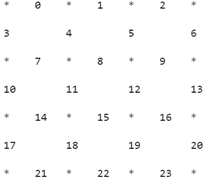

2.	Winning state of the game

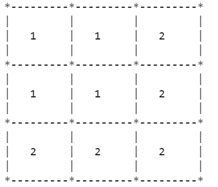


Game board sizes:
We can vary the game board by providing different number of rows and columns 


In [0]:
from google.colab import files

import numpy as np
import torch

import random
from copy import copy

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
rows = 3
cols = 3
global no_of_edges
no_of_edges = ((2*rows*cols) + rows + cols)
global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH

In [0]:
import copy
import random
import sys
def as_string(board_state):
    return ''.join([str(x) for x in board_state])

# Calculating the number of edges based on rows and columns and creatong those number of edges in lists
def init_board_state(board_size):
    rows = board_size[0]
    cols = board_size[1]
    return [0]*((2*rows*cols) + rows + cols)

# to represent the game in string format to print it on terminal
class ToString:
    def __init__(self):
        pass

    def apply(self, game):
        rows = game.get_board_size()[0]
        cols = game.get_board_size()[1]
        board_state = game.get_board_state()
        edge_to_boxes = self._get_edge_to_boxes(game.get_all_boxes())
        players = game.get_players()
        cur_index = 0
        board = ""
        for row in range(rows):
            if row == 0:
                for c in range(cols):
                    board += self._print_edges(c, board_state, cur_index)
                    cur_index += 1
                board += '  \n'
                board += self._print_spacer_line(cols, board_state, cur_index)
                board += '\n'

            for c in range(cols + 1):
                edge_val = "|" if self._is_edge_selected(board_state, cur_index) else cur_index
                board += '{0: <3}'.format(edge_val)
                if c < cols:
                    player_for_box = self._get_player_for_box(cur_index, edge_to_boxes, game, players)
                    if player_for_box is not None:
                        board += ' {0: <5.5} '.format(player_for_box)
                    else:
                        board += '       '
                cur_index += 1
            board += '\n'
            board += self._print_spacer_line(cols, board_state, cur_index - (cols + 1))
            board += '\n'

            for c in range(cols):
                board += self._print_edges(c, board_state, cur_index)
                cur_index += 1
            board += '  \n'
            if row != (rows - 1):
                board += self._print_spacer_line(cols, board_state, cur_index)
            board += '\n'
        board += self._print_player_scores(game, players)
        return board

    def _print_edges(self, c, board_state, cur_index):
        if c == 0:
            if self._is_edge_selected(board_state, cur_index):
                return '*---------*'
            return '*    {0: <3}  *'.format(cur_index)
        else:
            if self._is_edge_selected(board_state, cur_index):
                return '---------*'
            return '    {0: <3}  *'.format(cur_index)

    def _print_spacer_line(self, cols, board_state, i):
        line = ""
        for c in range(cols + 1):
            edge_val = "|" if self._is_edge_selected(board_state, i) else ''
            line += '{0: <3}'.format(edge_val)
            if c < cols:
                line += '       '
            i += 1
        return line

    def _is_edge_selected(self, board_state, edge_index):
        return board_state[edge_index] == 1

    def _get_edge_to_boxes(self, boxes):
        edge_to_boxes = {}
        for box in boxes:
            edge_to_boxes[box.get_edges()[1]] = box
        return edge_to_boxes

    def _get_player_for_box(self, edge, edge_to_boxes, game, players):
        box = edge_to_boxes[edge]
        for player in players:
            player_boxes = game.get_boxes(player)
            for player_box in player_boxes:
                if str(box) == str(player_box):
                    return player
        return None

    def _print_player_scores(self, game, players):
        scores = ""
        for i, player in enumerate(players):
            scores += "{0:}: {1:}".format(player, game.get_score(player))
            if i < len(players) - 1:
                scores += ", "
        return scores

# Game class which is actual representaion of game board
class Game:
    def __init__(self, board_size, players):
        
        # initailizing the game
        self._board_size = board_size
        self._players = players
        self._current_player = 0
        self._board_state = init_board_state(board_size)
        self._boxes = self._init_boxes()
        self._players_to_boxes = {}
        for player in players:
            self._players_to_boxes[player] = []
    # deep copying the current game state
    def copy(self):
        game_copy = Game(self._board_size,self._players)
        game_copy._board_size = self._board_size
        game_copy._board_state = copy.deepcopy(self._board_state)
        game_copy._boxes = copy.deepcopy(self._boxes)
        game_copy._current_player = self._current_player
        game_copy._players = copy.deepcopy(self._players)
        game_copy._players_to_boxes = copy.deepcopy(self._players_to_boxes)
        return game_copy
    
    # creating the box objects for all boxes
    def _init_boxes(self):
        boxes = []
        rows = self._board_size[0]
        cols = self._board_size[1]
        r_index = 0
        for r in range(rows):
            for c in range(cols):
                boxes.append(Box(r_index, r_index + cols, r_index + cols + 1, 2*cols + 1 + r_index))
                r_index += 1
            r_index += cols + 1
        return boxes
    # return game size(rows,cols)
    def get_board_size(self):
        return self._board_size[0], self._board_size[1]

    # return all player names
    def get_players(self):
        return [player for player in self._players]

    # return current game state
    def get_board_state(self):
        """
        The board edges are indexed as follows (for the 2x2 case):
        
        *  0  *  1  * 
        2     3     4
        *  5  *  6  *
        7     8     9
        *  10 *  11 *
        
        In the example above, if edges 1 and 5 are selected, the board state will be [0,1,0,0,0,1,0,0,0,0,0].
        :return: a binary list representing the board state 
        """
        return [s for s in self._board_state]
    # return current game state by rows and cols
    def get_board_state_by_rows_cols(self):
        """
        The board edges are indexed as follows (for the 2x2 case):
        
        *  0  *  1  * 
        2     3     4
        *  5  *  6  *
        7     8     9
        *  10 *  11 *
        
        In the example above, if edges 1 and 5 are selected, the board state will be [[0,1],[1,0],[0,0]]  [[0,0,0],[0,0,0]].
        :return: a binary list representing the board state 
        """
        board_state = [s for s in self._board_state]
        rows,cols = self.get_board_size()
        rows_state = []
        cols_state = []
        each_row_state = []
        each_col_state = []
        r = rows
        c = cols
        row_flag = True
        for i,each_edge in enumerate(board_state):
            if row_flag:
                each_row_state.append(i)
                c-=1
            else:
                each_col_state.append(i)
                c-=1
            if(row_flag and c==0):
                c= cols
                rows_state.append(each_row_state.copy())
                each_row_state.clear()
                row_flag = False
            elif(not row_flag and c==-1):
                c= cols
                cols_state.append(each_col_state.copy())
                each_col_state.clear()
                row_flag = True
        return rows_state,cols_state
    # selects the current edge and change the game state accordingly
    def select_edge(self, edge_index, player):
        """
        Selects an edge on the game board. 
        :param edge_index: the index of the edge to select 
        :param player: the player selecting the edge
        :return: the next player to play, or None if the game is finished, and the number of boxes made
        """
        if self.is_finished():
            raise Exception("game is finished")
        if edge_index < 0 or edge_index > len(self._board_state) - 1:
            raise Exception("invalid edge index: %s" % edge_index)
        if self._board_state[edge_index] == 1:
            raise Exception("edge already selected: %s" % edge_index)
        if player != self._players[self._current_player]:
            raise Exception("next player to play is: %s" % self._players[self._current_player])
        self._board_state[edge_index] = 1
        boxes_made = 0
        for box in self._boxes:
            if box.contains(edge_index) and box.is_complete(self._board_state) and box not in self._players_to_boxes[player]:
                self._players_to_boxes[player].append(box)
                boxes_made += 1
        if boxes_made == 0:
            self._current_player = (self._current_player + 1) % len(self._players)
        return self.get_current_player(), boxes_made
    # get the score for the given player
    def get_score(self, player):
        
        if player not in self._players:
            raise Exception("player not recognized: %s" % player)
        return len(self._players_to_boxes[player])
    # get whose turn is now
    def get_current_player(self):
        """
        Returns the current player to play, or None if the game is finished.
        :return: the current player to play, or None if the game is finished 
        """
        return None if self.is_finished() else self._players[self._current_player]
    # get all boxes owned by the player
    def get_boxes(self, player):
        if player not in self._players:
            raise Exception("player not recognized: %s" % player)
        return self._players_to_boxes[player]
    # returns all boxes
    def get_all_boxes(self):
        return [box for box in self._boxes]
    # checks whether game is completed
    def is_finished(self):
        """
        Whether the game is finished. The game is finished when all boxes are completed.
        :return: whether the game is finished
        """
        return sum(self._board_state) == len(self._board_state)

    def __str__(self):
        return ToString().apply(self)

# class which represnts the Box in game board
class Box:
    def __init__(self, edge1, edge2, edge3, edge4):
        self._edges = [edge1, edge2, edge3, edge4]

    def contains(self, edge):
        return edge in self._edges

    def get_edges(self):
        return [edge for edge in self._edges]
    # checks whether box is completed or not
    def is_complete(self, board_state):
        return board_state[self._edges[0]] == 1 and board_state[self._edges[1]] == 1 and \
               board_state[self._edges[2]] == 1 and board_state[self._edges[3]] == 1

    def __str__(self):
        return '-'.join([str(x) for x in self._edges])


inf = float("inf")






class EdgePreference():
    def __init__(self,edge_number, row_edge,up=0,down=0,left=0,right=0):
        self.edge_number = edge_number
        self.row_edge = row_edge
        self.up = up
        self.down = down
        self.left = left
        self.right = right

"""Each edge will be priotized based on the number of edges filled for this box"""
def get_spatial_locality_preference(rows_state,cols_state, board_state):
    
    edge_preferences = dict()
    edge_preference_class = []
    for i in range(len(board_state)):
        edge_preferences[i] = 0
    
    for i,each_row in enumerate(rows_state):
        if i!=0 and i!= len(rows_state)-1: 
            for j,each_row_edge in enumerate(each_row):
              if board_state[each_row_edge] ==0:
                each_edge_pref = EdgePreference(each_row_edge,True)
                if board_state[cols_state[i][j]]==1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.down += 1
                if board_state[cols_state[i][j+1]] == 1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.down += 1
                if board_state[rows_state[i+1][j]] == 1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.down += 1
                if board_state[cols_state[i-1][j]]==1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.up += 1
                if board_state[cols_state[i-1][j+1]] == 1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.up += 1
                if board_state[rows_state[i-1][j]] == 1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.up += 1
                edge_preference_class.append(each_edge_pref) 
        elif i == 0 :
            for j,each_row_edge in enumerate(each_row):
              if board_state[each_row_edge] ==0:
                each_edge_pref = EdgePreference(each_row_edge,True)
                if board_state[cols_state[i][j]]==1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.down += 1
                if board_state[cols_state[i][j+1]] == 1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.down += 1
                if board_state[rows_state[i+1][j]] == 1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.down += 1
                edge_preference_class.append(each_edge_pref) 
        elif i==len(rows_state)-1:
            for j,each_row_edge in enumerate(each_row):
              if board_state[each_row_edge] ==0:
                each_edge_pref = EdgePreference(each_row_edge,True)
                if board_state[cols_state[i-1][j]]==1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.up += 1
                if board_state[cols_state[i-1][j+1]] == 1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.up += 1
                if board_state[rows_state[i-1][j]] == 1:
                    edge_preferences[each_row_edge] += 1
                    each_edge_pref.up += 1
                edge_preference_class.append(each_edge_pref) 
        

                
    for i,each_col in enumerate(cols_state):
        
        for j,each_col_edge in enumerate(each_col):
          if board_state[each_col_edge] ==0:
            each_edge_pref = EdgePreference(each_col_edge,False)
            if j!= len(each_col)-1:
                if board_state[cols_state[i][j+1]]==1:
                    edge_preferences[each_col_edge] += 1
                    each_edge_pref.right +=1
                if board_state[rows_state[i][j]] == 1:
                    edge_preferences[each_col_edge] += 1
                    each_edge_pref.right +=1
                if board_state[rows_state[i+1][j]] == 1:
                    edge_preferences[each_col_edge] += 1
                    each_edge_pref.right +=1
            if j!=0:
                if board_state[cols_state[i][j-1]]==1:
                    edge_preferences[each_col_edge] += 1
                    each_edge_pref.left +=1
                if board_state[rows_state[i][j-1]] == 1:
                    edge_preferences[each_col_edge] += 1
                    each_edge_pref.left +=1
                if board_state[rows_state[i+1][j-1]] == 1:
                    edge_preferences[each_col_edge] += 1
                    each_edge_pref.left +=1
            edge_preference_class.append(each_edge_pref)
    return edge_preference_class

# sorting function based on the priority of the edges
def My_sort(edge_details):
    
    if(edge_details.row_edge):
        if(edge_details.up> edge_details.down):
            return edge_details.up
        return edge_details.down
    else:
        if(edge_details.right> edge_details.left):
            return edge_details.right
        return edge_details.left

"""Each edge will be priotized based on the number of edges filled for this box and then sorted
   them based on the priority
   if option is True then i am using this priority feature to get the random sampling
   or else i am using the trained data from the neural networks by calling getBestMoves()
"""
def getRandomSample(number_of_samples,edge_preferences,board_state,zero_indices,option=True):
    if option:# use spatial locality max queue preference
      edge_preferences = sorted(edge_preferences,key = My_sort,reverse=True)
      max_heap = []
      min_heap = []
      for each_edge_preference in edge_preferences:
          if each_edge_preference.edge_number in zero_indices:
              max_heap.append(each_edge_preference)
      for each_edge_preference in sorted(edge_preferences,key = My_sort):
          if each_edge_preference.edge_number in zero_indices:
              min_heap.append(each_edge_preference)
      if(max_heap[0].up ==3 or max_heap[0].down ==3 or max_heap[0].left ==3 or max_heap[0].right ==3 ):
          return [x.edge_number for x in max_heap][:number_of_samples]
      else:
          return [x.edge_number for x in min_heap][:number_of_samples]
    else:
      moves = getBestMoves(samples_1_Adam_TanH,board_state,5)
      if(len(moves) == 0):
        return getRandomSample(number_of_samples,edge_preferences,board_state,zero_indices,True)
      return getBestMoves(samples_1_Adam_TanH,board_state,5)


def minMax(game, player='AI', depth = 10, is_max = True, move =-1,NN=True ):
    
    zero_indices = []
   
    # get current board state
    board_state = game.get_board_state()
    rows_state,cols_state = game.get_board_state_by_rows_cols()

    edge_preferences = get_spatial_locality_preference(rows_state,cols_state,board_state)
    
    # store the edges which are available
    for i in range(len(board_state)):
        if board_state[i] == 0:
            zero_indices.append(i)
    # AI will try to comepete with the user who has highest score for each game state
    if len(zero_indices) == 0 or depth == 0:
        if (game.get_score("1")>game.get_score("2")):
            return [move, game.get_score("AI")-game.get_score("1"),edge_preferences]
        return [move, game.get_score("AI")-game.get_score("2"),edge_preferences]
    if NN:
      randomSampledEdges = list(getRandomSample(8,edge_preferences,board_state,zero_indices, option=False))
    else:
      randomSampledEdges = list(getRandomSample(8,edge_preferences,board_state,zero_indices, option=True))
    
    #if the current game not seen by neural network then randomly taking the edges
    if(len(randomSampledEdges)==0):
      random.shuffle(zero_indices)
      randomSampledEdges = zero_indices[:2]
    random.shuffle(randomSampledEdges)

    # AI turn in min max tree search
    if player=="AI":
        best_move =  -1
        best_score = -1000000
        random.shuffle(zero_indices)
        # print(randomSampledEdges)

        for x in randomSampledEdges:
            current = game.copy()
            current_player, _ = current.select_edge(x, player)
            temp = minMax(current,current_player, depth - 1, is_max, x,NN=NN)

            if temp[1] > best_score:
                best_move = x
                best_score = temp[1]
        return [best_move, best_score,edge_preferences]
    else:# remainig two players turn
        worse_move = -1
        worse_score = 100000
        for x in randomSampledEdges:
            current = game.copy()
            current_player, _ = current.select_edge(x, player)
            temp = minMax(current,current_player, depth - 1,  is_max, x,NN=NN)
            if temp[1] < worse_score:
                worse_move = x
                worse_score = temp[1]

        return [worse_move, worse_score,edge_preferences]
"""This is the BASELINE opponent which returns the next move  to take, 
if better_AI is false then we are simply taking taking the random edge from all available edge
else we are taking the edge according to the spatial locality concept which is introduced before"""
def random_move(game,better_AI=True):
  zero_indices = []
  board_state = game.get_board_state()
  rows_state,cols_state = game.get_board_state_by_rows_cols()
  for i in range(len(board_state)):
        if board_state[i] == 0:
            zero_indices.append(i)
  edge_preferences = get_spatial_locality_preference(rows_state,cols_state,board_state)
  randomSampledEdges = list(getRandomSample(1,edge_preferences,board_state,zero_indices, option=True))
    
  if(not better_AI):
    
    return random.choice(zero_indices)
  

  return randomSampledEdges[0]

# the main function which manages the turns between players
def main(board_rows,board_cols,NN=False):
    print("Play Game...")
    

    
    num_players = 3
    players = ["1","2","AI"]
    

    

    print("preparing game...")

    game = Game((board_rows, board_cols), players)
    print(game)
    while not game.is_finished():
        current_player = game.get_current_player()
        print(current_player)
        # input("h")
        
        if current_player in ['AI']:
            search = minMax(game,current_player, 5, True, -1,NN=NN)
            print(search[0],search[1])
            current_player, _ = game.select_edge(search[0], current_player)
        else:
            try:
                
                print("select your move: ".format(current_player))
                move = random_move(game)
                current_player, _ = game.select_edge(move, current_player)
            except Exception as e:
                print("illegal move selection.. select again ", str(e))
        print(game)
    scores = []
    for i, player in enumerate(game.get_players()):
            scores.append(game.get_score(player))
    return scores.copy()
    print(game)


In [0]:
def valid_moves(state):
    return list(np.where(np.array(state) == 0)[0])

In [0]:
def make_move(state, move):
    newState = state.copy()
    newState[move] = 1
    return newState

In [0]:
# to check whether the box is cretaed or not
def box_created_1(state, boxes):
    global rows,cols
    created = 0
    k = 0
    start_edge_box = [0]
    edge = 0
    box_num =0 
    while start_edge_box[-1] < (no_of_edges-1):
      start_edge_box += range(edge,edge+cols)
      edge = edge+2*cols+1
    start_edge_box = start_edge_box[1:]
    start_edge_box = start_edge_box[0:-cols]# removing the last row edges, because there will not be any boxes below that
    
    for i in start_edge_box:
      if i>=i+cols:
        break
     
      if state[i] == 1 and state[(i+cols)] == 1 and state[(i+cols+1)] == 1 and state[(i+2*cols+1)] == 1:
            if boxes[box_num] == 0:
                boxes[box_num] = 1
                created += 1
            
      
      box_num +=1
    return created, boxes


In [0]:
# to print the learning curve for all players
def plot_outcomes(outcomes, max_games, n_games):
    if n_games == 0:
        return
    n_bins = 100
    n_per = int(max_games/n_bins)
    outcome_rows = outcomes.reshape(-1, n_per)
    outcome_rows = outcome_rows[:int(n_games/float(n_per))+1, :]
    avgs = np.mean(outcome_rows, axis = 1)
    xs = np.linspace(n_per, n_games, len(avgs))
    plt.figure(figsize = (15, 10))
    plt.plot(xs, np.sum(outcome_rows == 1, axis = 1), 'g-', label='P1 wins')
    plt.plot(xs, np.sum(outcome_rows == 2, axis = 1), 'r-', label='P2 wins')
    plt.plot(xs, np.sum(outcome_rows == 3, axis = 1), 'b-', label='P3 wins')
    plt.legend(loc = "center")
    plt.ylabel('Number of Games\nin Bins of {:d}'.format(n_per))

In [0]:
# a neural network class which used for trainig the data

class PyTorchNN(torch.nn.Module):
    
    def __init__(self, n_inputs, network, n_outputs, relu=False):
        super(PyTorchNN, self).__init__()
        # adding input layer
        network_layers = [torch.nn.Linear(n_inputs, network[0])]
        # adding the hidden layers based on the activation function (Tanh/RELU)
        if len(network) > 1:
            network_layers.append(torch.nn.Tanh() if not relu else torch.nn.ReLU())
            for i in range(len(network)-1):
                network_layers.append(torch.nn.Linear(network[i], network[i+1]))
              
                network_layers.append(torch.nn.Tanh() if not relu else torch.nn.ReLU())
        # adding the output layer
        network_layers.append(torch.nn.Linear(network[-1], n_outputs))
        self.model = torch.nn.Sequential(*network_layers)
        self.Xmeans = None
        self.Tmeans = None
    
    def forward(self, X):
        return self.model(X) # Output of forward pass is passing data through the model
    # training the data  
    def train_pytorch(self, X, T, learning_rate, n_iterations, use_SGD=False):
        if self.Xmeans is None:
            self.Xmeans = X.mean(dim=0)
        if self.Tmeans is None:
            self.Tmeans = T.mean(dim=0)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate) if not use_SGD else torch.optim.SGD(self.parameters(), lr=learning_rate)
        loss_func = torch.nn.MSELoss()
        errors = []
        for iteration in range(n_iterations):
            # Forward pass
            outputs = self(X)
            loss = loss_func(outputs, T)
            errors.append(torch.sqrt(loss))
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
        return self, errors
    
    def use_pytorch(self, X):
        with torch.no_grad():
            return self(X).cpu().numpy() if torch.cuda.is_available() else self(X).numpy() # Returning Y

## Generating and updating the training data:


The flow of training the neural network is as follows:
1.	For each batch:
a.	Declare a sample list and initialize it as empty
b.	For each iteration:
i.	Take starting state of the game
ii.	Continue playing the game until it is over
1.	Assign an appropriate weight based on which player won the game
2.	Add this weight and maximum (neuralNetworkOuput) to the game state
iii.	Take state + moves from each sample list along with the weights and max(neuralNetworkOutput) which is taken as a target to neural network.
iv.	Train the neural network using above data. 


In [0]:
cuda_available = torch.cuda.is_available()

In [0]:
def tensor(np_array):
    return torch.from_numpy(np_array.astype('double')).cuda() if cuda_available else torch.from_numpy(np_array.astype('double'))

In [0]:
# takes the better move among all the moves considered until now
def epsilon_greedy(Qnet, state, valid_moves_F, turn):
    moves = valid_moves_F(state)
    Qs = []
    for m in moves:
        Qs.append(Qnet.use_pytorch(tensor(np.array(state + [m]))) if Qnet.Xmeans is not None else 0)
    move = moves[np.argmax(Qs)] 
    Q = np.max(Qs)
    return move, Q

In [0]:
#  trainig of the neural net
def train_Qnet(n_batches, n_reps_per_batch, network, n_iterations, learning_rate,
                valid_moves_F, make_move_F, boxes_created_F, relu=False, use_SGD=False):
    
    # use CUDA cores if available, else use CPU
    Qnet = PyTorchNN(2*(rows*cols)+rows+cols+1, network, 1, relu).to(torch.device('cuda' if cuda_available else 'cpu')).double()
    repk = -1
    outcomes = np.zeros(n_batches*n_reps_per_batch)
    for batch in range(n_batches):
        
        samples = []
        
        for reps in range(n_reps_per_batch):
            repk += 1
            
            # Initialize game
            state = [0]*no_of_edges
            boxes = [0]*(rows*cols)
            score = [0]*3
            done = False
            
            # Start game; player 1's turn initially
            turn = 0
            move, _ = epsilon_greedy(Qnet, state, valid_moves_F, turn)
            
            # Continue to play the game
            while not done:
                r = 0
                state_next = make_move_F(state, move)
                

                created, boxes = boxes_created_F(state_next, boxes) # Check how many boxes are created after making a move
                
                if created > 0: # If a box is created, update score of the player who made the move
                    if turn==0:
                        score[0] += created
                    elif turn==1:
                        score[1] += created
                    else:
                      score[2] += created
                else: # Else give turn to the other player
                    turn = (turn+1)%3
                
                if 0 not in state_next: # If there are no more edges remaining, the game is over
                    done = True # Set termination flag
                    Qnext = 0 # Determine the reinforcement
                    r=0
                    if(score[0]>score[1]):
                      if(score[0]>score[2]):
                        r = 1
                      else:
                        r = 3
                    elif score[1]>score[2]:
                      r=2
                    else:
                      r = 3
                    
                    outcomes[repk] = r
                   
                else: # Else, determine next move and add current sample with reinforcement 0
                    move_next, Qnext = epsilon_greedy(Qnet, state_next, valid_moves_F, turn)
                
                samples.append([*state, move, r, Qnext]) # Collect turn results as a sample
                state = state_next
                move = move_next
        
        samples = np.array(samples) # Samples contains the training inputs and the targets
        X = tensor(samples[:, :no_of_edges+1]) # Training inputs to the neural network
        T = tensor(samples[:, no_of_edges+1:no_of_edges+2]+samples[:, no_of_edges+2:no_of_edges+3]) # Target values for the neural network
        Qnet, _ = Qnet.train_pytorch(X, T, learning_rate, n_iterations, use_SGD) # Training the neural network
    
    print('DONE')
    
    return Qnet, outcomes, samples

### Parameter values \#1

In [0]:
# configuration 1
n_batches = 25
n_reps_per_batch = 1600
n_iterations = 100
global network
network = [2*rows+cols,cols]
learning_rate = 0.03


#### Adam, TanH

In [0]:
import numbers

# after training the data, this function will return the best move on the current game state
def getBestMoves(samples_1_Adam_TanH,cur_state,no_of_samples):
  all_states = samples_1_Adam_TanH.tolist()
  res =[]
  for each_state in all_states:
    if each_state[:-3]==cur_state:
      try:
        if(not isinstance(each_state[-1],numbers.Integral)):
          if isinstance(each_state[-1],np.float64):
            res.append((each_state[-3],each_state[-1]))
          else:
            print(each_state[-1],type(each_state[-1]))
            a= each_state[-1].tolist()[0]
            res.append((each_state[-3],a))
        else:
          res.append((each_state[-3],each_state[-1]))
      except Exception:
        continue

  res = sorted(res,key=lambda x : x[1],reverse=True)

  best_moves = set()

  for each_tu in res:
    if(len(best_moves) == no_of_samples):
      break  
    else:
      best_moves.add(each_tu[0])
  return best_moves


In [0]:
All_learning = []
# game starts here
def startGame():
  game_size_row_instances = [2,3,3,4,4]
  game_size_col_instances = [2,2,3,3,4]
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    # neural network configuration
    n_batches = 25
    n_reps_per_batch = 1600
    n_iterations = 100
    
    network = [2*rows+cols,cols]
    learning_rate = 0.03
    
    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, valid_moves,
                                                                         make_move, box_created_1)
    
    All_learning.append(outcomes_1_Adam_TanH)
    main(rows,cols)

startGame()


DONE
Play Game...
preparing game...
*    0    *    1    *  
                       
2         3         4  
                       
*    5    *    6    *  
                       
7         8         9  
                       
*    10   *    11   *  

1: 0, 2: 0, AI: 0
1
select your move: 
*---------*    1    *  
                       
2         3         4  
                       
*    5    *    6    *  
                       
7         8         9  
                       
*    10   *    11   *  

1: 0, 2: 0, AI: 0
2
select your move: 
*---------*---------*  
                       
2         3         4  
                       
*    5    *    6    *  
                       
7         8         9  
                       
*    10   *    11   *  

1: 0, 2: 0, AI: 0
AI
10 0
*---------*---------*  
                       
2         3         4  
                       
*    5    *    6    *  
                       
7         8         9  
                       
*---------*    11

In [0]:
for each_learn in All_learning:
  plot_outcomes(each_learn, 1000, 1000)

In [0]:
All_learning = []
AI_Outcomes = []
# starting 100 games on each instance of the game size without the nueral network
def startGame_AI():
  game_size_row_instances = [2,3,3]
  game_size_col_instances = [2,2,3]
  each_instance_outcome = dict()
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    network = [2*(rows+cols),cols]
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    # neural network configuration
    n_batches = 10
    n_reps_per_batch = 1000
    n_iterations = 50
    # network = [5]
    learning_rate = 0.02
    epsilon = 1
    epsilon_decay_factor = 0.98
    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    # Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
    #                                                                      n_iterations, learning_rate, epsilon,
    #                                                                      epsilon_decay_factor, valid_moves,
    #                                                                      make_move, box_created_1)
    # # plot_outcomes(outcomes_1_Adam_TanH, 1000, 1000)
    # All_learning.append(outcomes_1_Adam_TanH)
    for j in range(100):
      scores = main(rows,cols)
      each_instance_outcome[j] = scores.copy()
    AI_Outcomes.append(each_instance_outcome)
    AI_Outcomes
startGame_AI()

In [0]:
# starting 100 games on each instance of the game size with the nueral network
All_learning_NN = []
NN_Outcomes = []
def startGame_NN():
  game_size_row_instances = [2,3,3,4,4]
  game_size_col_instances = [2,2,3,3,4]
  each_instance_outcome = {}
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    network = [2*(rows+cols),cols]
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    # neural network configuration
    n_batches = 10
    n_reps_per_batch = 1000
    n_iterations = 50
    # network = [5]
    learning_rate = 0.02
    epsilon = 1
    epsilon_decay_factor = 0.98
    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, valid_moves,
                                                                         make_move, box_created_1,relu=True)
    # plot_outcomes(outcomes_1_Adam_TanH, 1000, 1000)
    All_learning.append(outcomes_1_Adam_TanH)
    for j in range(100):
      scores = main(rows,cols,NN=True)
      each_instance_outcome[j] = scores
    NN_Outcomes.append(each_instance_outcome)
  return NN_Outcomes
startGame_NN()

In [0]:
this is to calculate the win_ratio of AI
AI_score = 0
for each_outcome in NN_Outcomes:  
  for game in each_outcome:
    scores = each_outcome[game]
    if scores[2]>=scores[1] and scores[2] >= scores[0]:
      AI_score += 1
print("AI SCORE with NN" ,AI_score/2500)
AI_score = 0
for each_outcome in AI_Outcomes:
  for game in each_outcome:
    scores = each_outcome[game]
    if scores[2]>=scores[1] and scores[2] >= scores[0]:
      AI_score += 1
print("AI SCORE without NN", AI_score/2500)

#### Adam, RELU

In [0]:
# configuration 2
n_batches = 35
n_reps_per_batch = 1700
n_iterations = 150
global network
network = [2*rows+cols,cols]
learning_rate = 0.04

In [0]:
All_learning = []
# game starts here
def startGame():
  game_size_row_instances = [2,3,3,4,4]
  game_size_col_instances = [2,2,3,3,4]
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    # neural network configuration
    n_batches = 35
    n_reps_per_batch = 1700
    n_iterations = 150
    
    network = [2*rows+cols,cols]
    learning_rate = 0.04
    
    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, valid_moves,
                                                                         make_move, box_created_1,relu=True)
    
    All_learning.append(outcomes_1_Adam_TanH)
    main(rows,cols)

startGame()


In [0]:
for each_learn in All_learning:
  plot_outcomes(each_learn, 1000, 1000)

In [0]:
All_learning = []
AI_Outcomes = []
# starting 100 games on each instance of the game size without the nueral network
def startGame_AI():
  game_size_row_instances = [2,3,3,4,4]
  game_size_col_instances = [2,2,3,3,4]
  each_instance_outcome = dict()
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    network = [2*(rows+cols),cols]
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    
    for j in range(100):
      scores = main(rows,cols)
      each_instance_outcome[j] = scores.copy()
    AI_Outcomes.append(each_instance_outcome)
    AI_Outcomes
startGame_AI()

In [0]:
# starting 100 games on each instance of the game size with the nueral network
All_learning_NN = []
NN_Outcomes = []
def startGame_NN():
  game_size_row_instances = [2,3,3,4,4]
  game_size_col_instances = [2,2,3,3,4]
  each_instance_outcome = {}
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    network = [2*(rows+cols),cols]
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, valid_moves,
                                                                         make_move, box_created_1,relu=True)
   
    All_learning.append(outcomes_1_Adam_TanH)
    for j in range(100):
      scores = main(rows,cols,NN=True)
      each_instance_outcome[j] = scores
    NN_Outcomes.append(each_instance_outcome)
  return NN_Outcomes
startGame_NN()

In [0]:
#this is to calculate the win_ratio of AI
AI_score = 0
# for each_outcome in NN_Outcomes:  
#   for game in each_outcome:
#     scores = each_outcome[game]
#     if scores[2]>=scores[1] and scores[2] >= scores[0]:
#       AI_score += 1
# print("AI SCORE with NN" ,AI_score/2500)
AI_score = 0
for each_outcome in AI_Outcomes:
  print(1)
  for game in each_outcome:
    scores = each_outcome[game]
    if scores[2]>=scores[1] and scores[2] >= scores[0]:
      AI_score += 1
print("AI SCORE without NN", AI_score/2500)

#### SGD, Tanh

In [0]:
# configuration 3
n_batches = 40
n_reps_per_batch = 2000
n_iterations = 160
global network
network = [2*rows+cols,cols]
learning_rate = 0.025

In [0]:
All_learning = []
# game starts here
def startGame():
  game_size_row_instances = [2,3,3,4,4]
  game_size_col_instances = [2,2,3,3,4]
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    
    
    network = [2*rows+cols,cols]
    
    
    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, valid_moves,
                                                                         make_move, box_created_1,use_SGD=True)
    
    All_learning.append(outcomes_1_Adam_TanH)
    main(rows,cols)

startGame()


In [0]:
for each_learn in All_learning:
  plot_outcomes(each_learn, 1000, 1000)

In [0]:
All_learning = []
AI_Outcomes = []
# starting 100 games on each instance of the game size without the nueral network
def startGame_AI():
  game_size_row_instances = [2,3,3,4,4]
  game_size_col_instances = [2,2,3,3,4]
  each_instance_outcome = dict()
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    network = [2*(rows+cols),cols]
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    
    for j in range(100):
      scores = main(rows,cols)
      each_instance_outcome[j] = scores.copy()
    AI_Outcomes.append(each_instance_outcome)
    AI_Outcomes
startGame_AI()

In [0]:
# starting 100 games on each instance of the game size with the nueral network
All_learning_NN = []
NN_Outcomes = []
def startGame_NN():
  game_size_row_instances = [2,3,3,4,4]
  game_size_col_instances = [2,2,3,3,4]
  each_instance_outcome = {}
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    network = [2*(rows+cols),cols]
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, valid_moves,
                                                                         make_move, box_created_1,use_SGD=True)
   
    All_learning.append(outcomes_1_Adam_TanH)
    for j in range(100):
      scores = main(rows,cols,NN=True)
      each_instance_outcome[j] = scores
    NN_Outcomes.append(each_instance_outcome)
  return NN_Outcomes
startGame_NN()

In [0]:
this is to calculate the win_ratio of AI
AI_score = 0
for each_outcome in NN_Outcomes:  
  for game in each_outcome:
    scores = each_outcome[game]
    if scores[2]>=scores[1] and scores[2] >= scores[0]:
      AI_score += 1
print("AI SCORE with NN" ,AI_score/2500)
AI_score = 0
for each_outcome in AI_Outcomes:
  for game in each_outcome:
    scores = each_outcome[game]
    if scores[2]>=scores[1] and scores[2] >= scores[0]:
      AI_score += 1
print("AI SCORE without NN", AI_score/2500)

#### SGD, RELU

In [0]:
# configuration 4
n_batches = 30
n_reps_per_batch = 1500
n_iterations = 125
global network
network = [2*(rows+cols),cols]
learning_rate = 0.02

In [0]:
All_learning = []
# game starts here
def startGame():
  game_size_row_instances = [2,3,3,4,4]
  game_size_col_instances = [2,2,3,3,4]
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    # neural network configuration
    n_batches = 35
    n_reps_per_batch = 1700
    n_iterations = 150
    
    network = [2*rows+cols,cols]
    learning_rate = 0.04
    
    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, valid_moves,
                                                                         make_move, box_created_1,use_SGD=True,relu=True)
    
    All_learning.append(outcomes_1_Adam_TanH)
    main(rows,cols)

startGame()


In [0]:
for each_learn in All_learning:
  plot_outcomes(each_learn, 1000, 1000)

In [0]:
All_learning = []
AI_Outcomes = []
# starting 100 games on each instance of the game size without the nueral network
def startGame_AI():
  game_size_row_instances = [2,3,3,4,4]
  game_size_col_instances = [2,2,3,3,4]
  each_instance_outcome = dict()
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    network = [2*(rows+cols),cols]
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    
    for j in range(100):
      scores = main(rows,cols)
      each_instance_outcome[j] = scores.copy()
    AI_Outcomes.append(each_instance_outcome)
    AI_Outcomes
startGame_AI()

In [0]:
# starting 100 games on each instance of the game size with the nueral network
All_learning_NN = []
NN_Outcomes = []
def startGame_NN():
  game_size_row_instances = [2,3,3,4,4]
  game_size_col_instances = [2,2,3,3,4]
  each_instance_outcome = {}
  for i in range(len(game_size_row_instances)):
    global rows,cols,no_of_edges,network
    network = [2*(rows+cols),cols]
    rows = game_size_row_instances[i]
    cols = game_size_col_instances[i]
    no_of_edges = ((2*rows*cols) + rows + cols)

    np.set_printoptions(threshold=np.inf)
    global Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH
    Qnet_1_Adam_TanH, outcomes_1_Adam_TanH, samples_1_Adam_TanH = train_Qnet(n_batches, n_reps_per_batch, network,
                                                                         n_iterations, learning_rate, valid_moves,
                                                                         make_move, box_created_1,use_SGD=True,relu=True)
   
    All_learning.append(outcomes_1_Adam_TanH)
    for j in range(100):
      scores = main(rows,cols,NN=True)
      each_instance_outcome[j] = scores
    NN_Outcomes.append(each_instance_outcome)
  return NN_Outcomes
startGame_NN()

In [0]:
this is to calculate the win_ratio of AI
AI_score = 0
for each_outcome in NN_Outcomes:  
  for game in each_outcome:
    scores = each_outcome[game]
    if scores[2]>=scores[1] and scores[2] >= scores[0]:
      AI_score += 1
print("AI SCORE with NN" ,AI_score/1500)
AI_score = 0
for each_outcome in AI_Outcomes:
  for game in each_outcome:
    scores = each_outcome[game]
    if scores[2]>=scores[1] and scores[2] >= scores[0]:
      AI_score += 1
print("AI SCORE without NN", AI_score/1500)